# Sonar Returns

This dataset was obtained by bouncing sonar off of mines (metal cylinders) and rocks and observing the different responses in order to be able to tell which are which, so that sonar can be used as a reliable predictor. The dataset contains 111 mine observations and 97 rock observations, as well as the signals obtained by each sensor. The dataset has many features, so it is ideal for algorithms which inherently select for features, but perhaps there is also opportunity to use more traditional classification algorithms in the presence of feature selection.

<img src="sonar.jpeg" style="height: 400px; width:auto;"></br></br>

# Import Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("sonar.csv")
df.head().transpose()

,0,1,2,3,4
f1,0.02,0.0453,0.0262,0.01,0.0762
f2,0.0371,0.0523,0.0582,0.0171,0.0666
f3,0.0428,0.0843,0.1099,0.0623,0.0481
f4,0.0207,0.0689,0.1083,0.0205,0.0394
f5,0.0954,0.1183,0.0974,0.0205,0.059
...,...,...,...,...,...
f57,0.018,0.014,0.0316,0.005,0.0072
f58,0.0084,0.0049,0.0164,0.0044,0.0048
f59,0.009,0.0052,0.0095,0.004,0.0107
f60,0.0032,0.0044,0.0078,0.0117,0.0094


# Inspect Data

In [3]:
shape = df.shape
print(shape)

(208, 61)


In [4]:
class_counts = df.groupby('class').size()
print(class_counts)

class
M    111
R     97
dtype: int64


In [5]:
df.describe().transpose().head()

,count,mean,std,min,25%,50%,75%,max
f1,208.0,0.029164,0.022991,0.0015,0.013350,0.02280,0.035550,0.1371
f2,208.0,0.038437,0.032960,0.0006,0.016450,0.03080,0.047950,0.2339
f3,208.0,0.043832,0.038428,0.0015,0.018950,0.03430,0.057950,0.3059
f4,208.0,0.053892,0.046528,0.0058,0.024375,0.04405,0.064500,0.4264
f5,208.0,0.075202,0.055552,0.0067,0.038050,0.06250,0.100275,0.4010


# Visualization

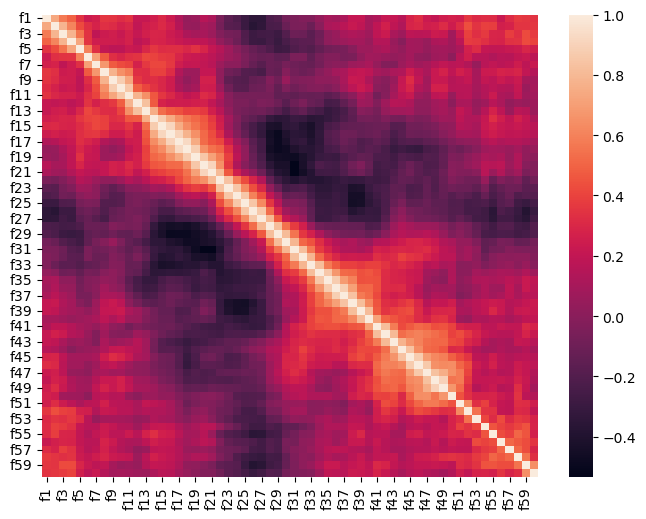

In [6]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr());

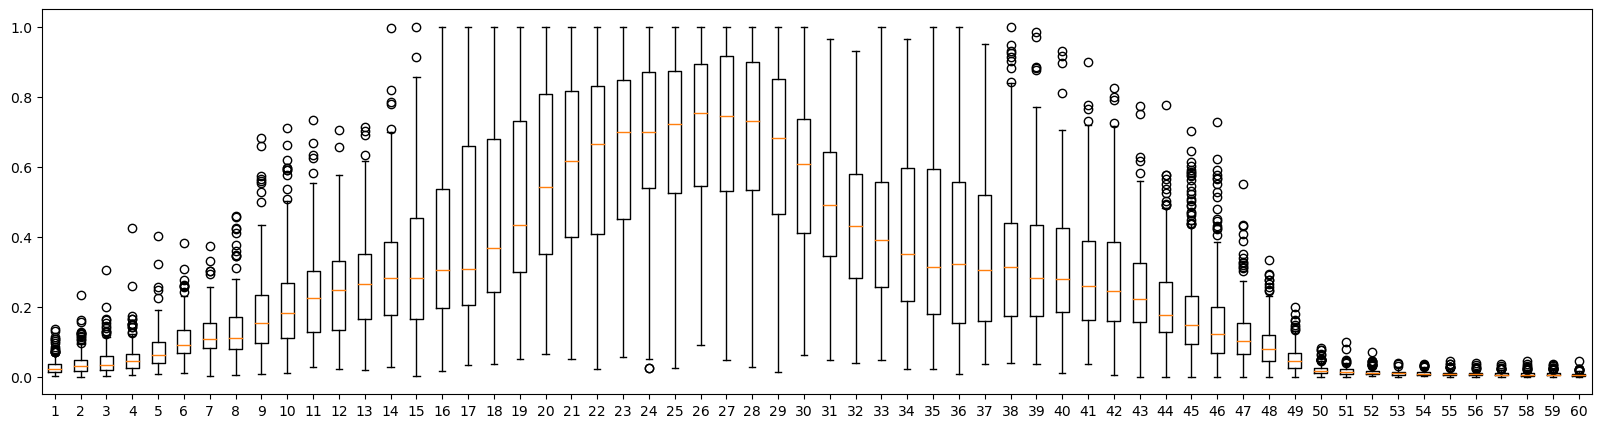

In [7]:
plt.figure(figsize=(20,5))
plt.boxplot(df.drop(columns="class"))
plt.show()

# Preprocessing

### Label Encoding Target

In [8]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['class'])
transform = le.transform(df['class'])
df['class'] = transform
df['class']

0      1
1      1
2      1
3      1
4      1
      ..
203    0
204    0
205    0
206    0
207    0
Name: class, Length: 208, dtype: int32

### Train/Test Split

In [9]:
array = df.values
X = array[:,0:60]
y = array[:,60]

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2, random_state=123)

### Standardization

In [11]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# Classification Algorithms

In [12]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=20, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.765 (0.125)
LDA: 0.751 (0.115)
KNN: 0.733 (0.199)
CART: 0.717 (0.187)
NB: 0.669 (0.130)
SVM: 0.655 (0.144)


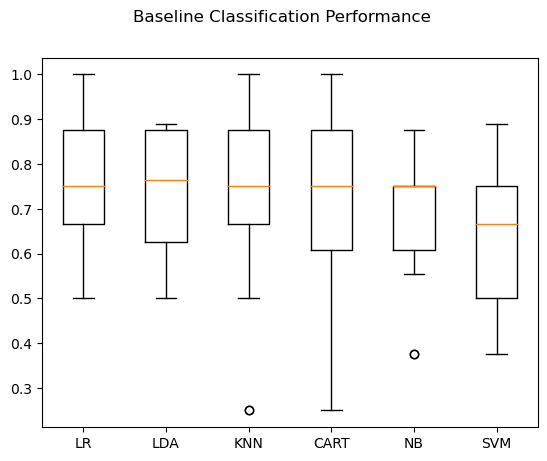

In [13]:
fig = plt.figure()
fig.suptitle('Baseline Classification Performance')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Feature Selection

### Variance Thresholding

In [14]:
from sklearn.feature_selection import VarianceThreshold
thresholder = VarianceThreshold(threshold=.05)
X_higher_05 = thresholder.fit_transform(X_train)
print(X_higher_05.shape)

(166, 18)


In [15]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=20, shuffle=True)
    cv_results = cross_val_score(model, X_higher_05, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.661806 (0.138002)
LDA: 0.627083 (0.169779)
KNN: 0.663889 (0.180427)
CART: 0.705556 (0.145840)
NB: 0.643056 (0.176673)
SVM: 0.600000 (0.185800)


### F-Stat Based Selection

In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
fvalue_selector = SelectKBest(f_classif, k=20)
X_kbest = fvalue_selector.fit_transform(X, y)
print('Original number of features:', X.shape[1])
print('Reduced number of features:', X_kbest.shape[1])

Original number of features: 60
Reduced number of features: 20


In [17]:
from sklearn.model_selection import train_test_split
X_train_kbest, X_test_kbest, y_train_kbest, y_test_kbest = train_test_split(X, y,test_size=.2, shuffle=True)

In [18]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=20, shuffle=True)
    cv_results = cross_val_score(model, X_train_kbest, y_train_kbest, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.760 (0.150)
LDA: 0.761 (0.180)
KNN: 0.776 (0.158)
CART: 0.710 (0.156)
NB: 0.683 (0.137)
SVM: 0.560 (0.162)


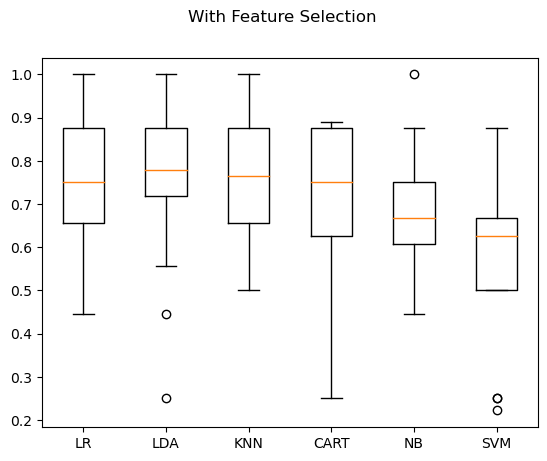

In [19]:
fig = plt.figure()
fig.suptitle('With Feature Selection')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Impact of Standardization

In [20]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=20, shuffle=True)
    cv_results = cross_val_score(model, X_train_std, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.785 (0.114)
LDA: 0.745 (0.163)
KNN: 0.790 (0.181)
CART: 0.721 (0.169)
NB: 0.647 (0.178)
SVM: 0.809 (0.112)


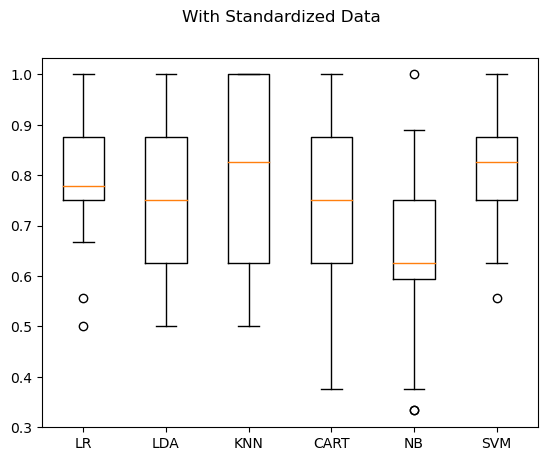

In [21]:
fig = plt.figure()
fig.suptitle('With Standardized Data')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Ensemble Algorithms

In [22]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier

num_folds = 10
scoring = 'accuracy'

ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
ensembles.append(('BG', BaggingClassifier()))
ensembles.append(('XGB', XGBClassifier()))

results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

AB: 0.783 (0.088)
GBM: 0.825 (0.057)
RF: 0.802 (0.078)
ET: 0.851 (0.088)
BG: 0.795 (0.084)
XGB: 0.820 (0.083)


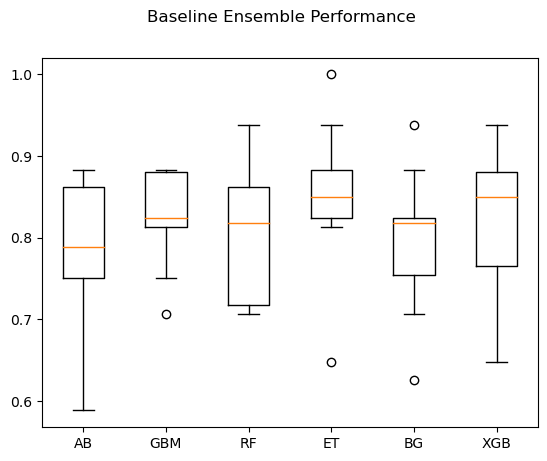

In [23]:
fig = plt.figure()
fig.suptitle('Baseline Ensemble Performance')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Impact of Feature Selection

AB: 0.758 (0.077)
GBM: 0.821 (0.114)
RF: 0.802 (0.095)
ET: 0.860 (0.075)
BG: 0.795 (0.077)
XGB: 0.831 (0.076)


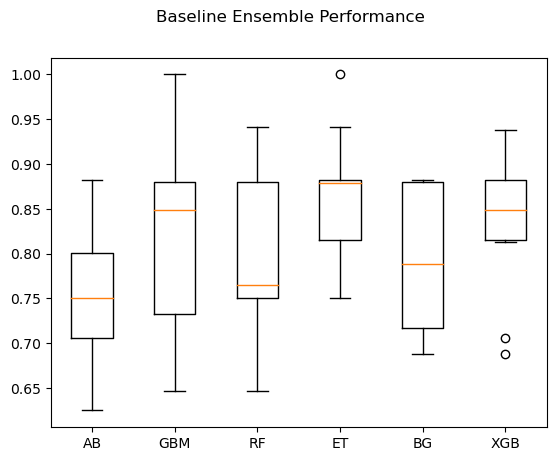

In [24]:
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, shuffle=True)
    cv_results = cross_val_score(model, X_train_kbest, y_train_kbest, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
fig = plt.figure()
fig.suptitle('Baseline Ensemble Performance')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Impact of Standardization

In [25]:
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, shuffle=True)
    cv_results = cross_val_score(model, X_train_std, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

AB: 0.793 (0.110)
GBM: 0.825 (0.075)
RF: 0.836 (0.092)
ET: 0.842 (0.106)
BG: 0.742 (0.106)
XGB: 0.818 (0.119)


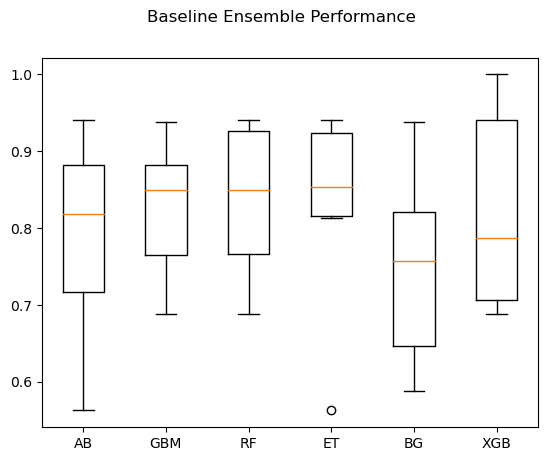

In [26]:
fig = plt.figure()
fig.suptitle('Baseline Ensemble Performance')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Tuning

In [27]:
from sklearn.model_selection import GridSearchCV

In [28]:
tuning_df = pd.DataFrame(columns = ('Model', 'Score', 'Param1', 'Param1_Val', 'Param2', 'Param2_Val', 'Param3', 'Param3_Val',  
                                   'Param4', 'Param4_Val', 'Param5', 'Param5_Val'))

def append_results_df(model, score, param1, param1_val, param2, param2_val, param3, param3_val, param4, param4_val, param5, param5_val):
    new_row = len(tuning_df) + 1
    tuning_df.loc[new_row,'Model'] = model
    tuning_df.loc[new_row,'Score'] = score
    tuning_df.loc[new_row,'Param1'] = param1
    tuning_df.loc[new_row,'Param1_Val'] = param1_val
    tuning_df.loc[new_row,'Param2'] = param2
    tuning_df.loc[new_row,'Param2_Val'] = param2_val
    tuning_df.loc[new_row,'Param3'] = param3
    tuning_df.loc[new_row,'Param3_Val'] = param3_val
    tuning_df.loc[new_row,'Param4'] = param4
    tuning_df.loc[new_row,'Param4_Val'] = param4_val
    tuning_df.loc[new_row,'Param5'] = param5
    tuning_df.loc[new_row,'Param5_Val'] = param5_val

### Logistic Regression, Standardized Data

In [29]:
Cs = np.array([1,0.1,0.01,0.001])
penalty = np.array(['l1', 'l2', 'elasticnet', 'none'])
class_weight = np.array(['balanced', None])

param_grid = dict(C=Cs, penalty=penalty, class_weight=class_weight) 
model = LogisticRegression()
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=20)

In [30]:
grid.fit(X_train_std, y_train)

model = "Logistic Regression, Standardized Data"
score = round(grid.best_score_,3)
param1 = "c"
param1_val = grid.best_estimator_.C
param2 = "class_weight"
param2_val = grid.best_estimator_.class_weight
param3 = "penalty"
param3_val = grid.best_estimator_.penalty
param4 = "solver"
param4_val = grid.best_estimator_.solver
param5 = ""
param5_val = ""

append_results_df(model,score,param1,param1_val,param2,param2_val,param3,param3_val,param4,param4_val,param5,param5_val)

In [31]:
tuning_df

,Model,Score,Param1,Param1_Val,Param2,Param2_Val,Param3,Param3_Val,Param4,Param4_Val,Param5,Param5_Val
1,"Logistic Regression, Standardized Data",0.792,c,0.1,class_weight,balanced,penalty,l2,solver,lbfgs,,


### KNN, Standardized Data

In [32]:
neighbors = np.array([2,3,4,5,6,7])
p = np.array([1,2])
algorithm = np.array(['auto', 'ball_tree', 'kd_tree', 'brute'])
param_grid = dict(n_neighbors=neighbors, p=p, algorithm=algorithm)
model = KNeighborsClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=20)

In [33]:
grid.fit(X_train_std, y_train)

model = "KNN, Standardized Data"
score = round(grid.best_score_,3)
param1 = "n_neighbors"
param1_val = grid.best_estimator_.n_neighbors
param2 = "p"
param2_val = grid.best_estimator_.p
param3 = "algorithm"
param3_val = grid.best_estimator_.algorithm
param4 = ""
param4_val = ""
param5 = ""
param5_val = ""

append_results_df(model,score,param1,param1_val,param2,param2_val,param3,param3_val,param4,param4_val,param5,param5_val)

In [34]:
tuning_df

,Model,Score,Param1,Param1_Val,Param2,Param2_Val,Param3,Param3_Val,Param4,Param4_Val,Param5,Param5_Val
1,"Logistic Regression, Standardized Data",0.792,c,0.1,class_weight,balanced,penalty,l2,solver,lbfgs,,
2,"KNN, Standardized Data",0.812,n_neighbors,3,p,1,algorithm,auto,,,,


### Adaboost, Unscaled Data

In [35]:
LRs = np.array([1,0.1,0.01,0.001])
n_est = np.array([10,20,30,40,50,60,70,80,90,100])
param_grid = dict(learning_rate=LRs, n_estimators=n_est) 
model = AdaBoostClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

In [36]:
grid.fit(X_train, y_train)

model = "Adaboost, Unscaled Data"
score = round(grid.best_score_,3)
param1 = "learning_rate"
param1_val = grid.best_estimator_.learning_rate
param2 = "n_estimators"
param2_val = grid.best_estimator_.n_estimators
param3 = ""
param3_val = ""
param4 = ""
param4_val = ""
param5 = ""
param5_val = ""

append_results_df(model,score,param1,param1_val,param2,param2_val,param3,param3_val,param4,param4_val,param5,param5_val)

In [37]:
tuning_df

,Model,Score,Param1,Param1_Val,Param2,Param2_Val,Param3,Param3_Val,Param4,Param4_Val,Param5,Param5_Val
1,"Logistic Regression, Standardized Data",0.792,c,0.1,class_weight,balanced,penalty,l2,solver,lbfgs,,
2,"KNN, Standardized Data",0.812,n_neighbors,3,p,1,algorithm,auto,,,,
3,"Adaboost, Unscaled Data",0.819,learning_rate,1.0,n_estimators,50,,,,,,


### Extra Trees, Unscaled Data

In [38]:
n_est = np.array([25,50,75,100,125,150])
max_depth = np.array([2,3,4,5,6,7,8,9])
param_grid = dict(n_estimators=n_est, max_depth=max_depth)
model = ExtraTreesClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

In [39]:
grid.fit(X_train, y_train)

model = "ExtraTrees, Unscaled Data"
score = round(grid.best_score_,3)
param1 = "n_estimators"
param1_val = grid.best_estimator_.n_estimators
param2 = "max_depth"
param2_val = grid.best_estimator_.max_depth
param3 = ""
param3_val = ""
param4 = ""
param4_val = ""
param5 = ""
param5_val = ""

append_results_df(model,score,param1,param1_val,param2,param2_val,param3,param3_val,param4,param4_val,param5,param5_val)

In [40]:
tuning_df

,Model,Score,Param1,Param1_Val,Param2,Param2_Val,Param3,Param3_Val,Param4,Param4_Val,Param5,Param5_Val
1,"Logistic Regression, Standardized Data",0.792,c,0.1,class_weight,balanced,penalty,l2,solver,lbfgs,,
2,"KNN, Standardized Data",0.812,n_neighbors,3,p,1,algorithm,auto,,,,
3,"Adaboost, Unscaled Data",0.819,learning_rate,1.0,n_estimators,50,,,,,,
4,"ExtraTrees, Unscaled Data",0.874,n_estimators,125,max_depth,8,,,,,,


### Gradient Boosting Machine, Unscaled Data

In [41]:
LRs = np.array([1,0.1,0.01,0.001])
n_est = np.array([90,100,110,120])
loss = np.array(['deviance', 'exponential'])
min_samples_leaf = np.array([1,2,3])
max_depth = np.array([2,3,4,5])

param_grid = dict(learning_rate=LRs, n_estimators=n_est, loss=loss, min_samples_leaf=min_samples_leaf, max_depth=max_depth) 
model = GradientBoostingClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

In [42]:
grid.fit(X_train_std, y_train)

model = "GBM, Unscaled Data"
score = round(grid.best_score_,3)
param1 = "learning_rate"
param1_val = grid.best_estimator_.learning_rate
param2 = "n_estimators"
param2_val = grid.best_estimator_.n_estimators
param3 = "loss"
param3_val = grid.best_estimator_.loss
param4 = "min_samples_leaf"
param4_val = grid.best_estimator_.min_samples_leaf
param5 = "max_depth"
param5_val = grid.best_estimator_.max_depth

append_results_df(model,score,param1,param1_val,param2,param2_val,param3,param3_val,param4,param4_val,param5,param5_val)

In [43]:
tuning_df

,Model,Score,Param1,Param1_Val,Param2,Param2_Val,Param3,Param3_Val,Param4,Param4_Val,Param5,Param5_Val
1,"Logistic Regression, Standardized Data",0.792,c,0.1,class_weight,balanced,penalty,l2,solver,lbfgs,,
2,"KNN, Standardized Data",0.812,n_neighbors,3,p,1,algorithm,auto,,,,
3,"Adaboost, Unscaled Data",0.819,learning_rate,1.0,n_estimators,50,,,,,,
4,"ExtraTrees, Unscaled Data",0.874,n_estimators,125,max_depth,8,,,,,,
5,"GBM, Unscaled Data",0.861,learning_rate,1.0,n_estimators,110,loss,exponential,min_samples_leaf,1,max_depth,3


### Random Forest, Unscaled Data

In [44]:
n_est = np.array([10,20,30,40,50,60])
criterion = np.array(['gini', 'entropy'])
max_depth = np.array([10,20,30,40,50,60,70])
max_leaf_nodes = np.array([280,290,300,310,320])

param_grid = dict(n_estimators=n_est, criterion=criterion, max_depth=max_depth, max_leaf_nodes=max_leaf_nodes)
model = RandomForestClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

In [45]:
grid.fit(X_train, y_train)

model = "Random Forest, Unscaled Data"
score = round(grid.best_score_,3)
param1 = "n_estimators"
param1_val = grid.best_estimator_.n_estimators
param2 = "criterion"
param2_val = grid.best_estimator_.criterion
param3 = "max_depth"
param3_val = grid.best_estimator_.max_depth
param4 = "max_leaf_nodes"
param4_val = grid.best_estimator_.max_leaf_nodes
param5 = ""
param5_val = ""

append_results_df(model,score,param1,param1_val,param2,param2_val,param3,param3_val,param4,param4_val,param5,param5_val)

In [46]:
tuning_df

,Model,Score,Param1,Param1_Val,Param2,Param2_Val,Param3,Param3_Val,Param4,Param4_Val,Param5,Param5_Val
1,"Logistic Regression, Standardized Data",0.792,c,0.1,class_weight,balanced,penalty,l2,solver,lbfgs,,
2,"KNN, Standardized Data",0.812,n_neighbors,3,p,1,algorithm,auto,,,,
3,"Adaboost, Unscaled Data",0.819,learning_rate,1.0,n_estimators,50,,,,,,
4,"ExtraTrees, Unscaled Data",0.874,n_estimators,125,max_depth,8,,,,,,
5,"GBM, Unscaled Data",0.861,learning_rate,1.0,n_estimators,110,loss,exponential,min_samples_leaf,1,max_depth,3
6,"Random Forest, Unscaled Data",0.85,n_estimators,30,criterion,entropy,max_depth,20,max_leaf_nodes,280,,


### XGBoost, Standardized Data

In [47]:
n_est = np.array([5,10,20,30,40,50,60])
max_depth = np.array([1,2,3])
reg_alpha = np.array([10,1,.1,.01,.001])
reg_lambda = np.array([10,1,.1,.01,.001])

param_grid = dict(n_estimators=n_est, max_depth=max_depth, reg_alpha=reg_alpha, reg_lambda=reg_lambda)
model = XGBClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

In [48]:
grid.fit(X_train_std, y_train)

model = "XGBoost, Standardized Data"
score = round(grid.best_score_,3)
param1 = "n_estimators"
param1_val = grid.best_estimator_.n_estimators
param2 = "max_depth"
param2_val = grid.best_estimator_.max_depth
param3 = "reg_alpha"
param3_val = grid.best_estimator_.reg_alpha
param4 = "reg_lambda"
param4_val = grid.best_estimator_.reg_lambda
param5 = ""
param5_val = ""

append_results_df(model,score,param1,param1_val,param2,param2_val,param3,param3_val,param4,param4_val,param5,param5_val)

In [49]:
tuning_df

,Model,Score,Param1,Param1_Val,Param2,Param2_Val,Param3,Param3_Val,Param4,Param4_Val,Param5,Param5_Val
1,"Logistic Regression, Standardized Data",0.792,c,0.1,class_weight,balanced,penalty,l2,solver,lbfgs,,
2,"KNN, Standardized Data",0.812,n_neighbors,3,p,1,algorithm,auto,,,,
3,"Adaboost, Unscaled Data",0.819,learning_rate,1.0,n_estimators,50,,,,,,
4,"ExtraTrees, Unscaled Data",0.874,n_estimators,125,max_depth,8,,,,,,
5,"GBM, Unscaled Data",0.861,learning_rate,1.0,n_estimators,110,loss,exponential,min_samples_leaf,1,max_depth,3
6,"Random Forest, Unscaled Data",0.85,n_estimators,30,criterion,entropy,max_depth,20,max_leaf_nodes,280,,
7,"XGBoost, Standardized Data",0.85,n_estimators,50,max_depth,2,reg_alpha,0.01,reg_lambda,0.01,,


# Performance Upon Test Set

In [88]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [89]:
testing_df = pd.DataFrame(columns = ('Model', 'Score'))

def append_testing_df(model, score):
    new_row = len(testing_df) + 1
    testing_df.loc[new_row,'Model'] = model
    testing_df.loc[new_row,'Score'] = score

### Logistic Regression, Standardized Data

In [90]:
LR = tuning_df[tuning_df['Model'] == 'Logistic Regression, Standardized Data']
LR

,Model,Score,Param1,Param1_Val,Param2,Param2_Val,Param3,Param3_Val,Param4,Param4_Val,Param5,Param5_Val
1,"Logistic Regression, Standardized Data",0.792,c,0.1,class_weight,balanced,penalty,l2,solver,lbfgs,,


In [91]:
LR_c = LR['Param1_Val'][1]
LR_class_weight = LR['Param2_Val'][1]
LR_penalty = LR['Param3_Val'][1]
LR_solver = LR['Param4_Val'][1]

In [92]:
model = LogisticRegression(C=LR_c, class_weight=LR_class_weight, penalty=LR_penalty, solver=LR_solver)
model.fit(X_train_std, y_train)
predictions = model.predict(X_test_std)

append_testing_df("Logistic Regression, Standardized Data", round(accuracy_score(y_test, predictions),3))

print("Logistic Regression on the Test Set")
print(round(accuracy_score(y_test, predictions),3))
print("")
print("Confusion Matrix")
print(confusion_matrix(y_test, predictions)) 

Logistic Regression on the Test Set
0.738

Confusion Matrix
[[17  4]
 [ 7 14]]


### KNN, Standardized Data

In [93]:
KNN = tuning_df[tuning_df['Model'] == 'KNN, Standardized Data']
KNN

,Model,Score,Param1,Param1_Val,Param2,Param2_Val,Param3,Param3_Val,Param4,Param4_Val,Param5,Param5_Val
2,"KNN, Standardized Data",0.812,n_neighbors,3,p,1,algorithm,auto,,,,


In [94]:
KNN_n_neighbors = KNN['Param1_Val'][2]
KNN_p = KNN['Param2_Val'][2]
KNN_algorithm = KNN['Param3_Val'][2]

In [95]:
model = KNeighborsClassifier(n_neighbors = KNN_n_neighbors, 
                             p = KNN_p,
                             algorithm = KNN_algorithm)
model.fit(X_train_std, y_train)
predictions = model.predict(X_test_std)

append_testing_df("KNN, Standardized Data", round(accuracy_score(y_test, predictions),3))

print("KNN on the Test Set")
print(round(accuracy_score(y_test, predictions),3))
print("")
print("Confusion Matrix")
print(confusion_matrix(y_test, predictions))

KNN on the Test Set
0.929

Confusion Matrix
[[21  0]
 [ 3 18]]


### Adaboost, Unscaled Data

In [96]:
Ada = tuning_df[tuning_df['Model'] == 'Adaboost, Unscaled Data']
Ada

,Model,Score,Param1,Param1_Val,Param2,Param2_Val,Param3,Param3_Val,Param4,Param4_Val,Param5,Param5_Val
3,"Adaboost, Unscaled Data",0.819,learning_rate,1.0,n_estimators,50,,,,,,


In [97]:
Ada_learning_rate = Ada['Param1_Val'][3]
Ada_n_estimators = Ada['Param2_Val'][3]

In [98]:
model = AdaBoostClassifier(learning_rate=Ada_learning_rate, n_estimators=Ada_n_estimators)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

append_testing_df("Adaboost, Unscaled Data", round(accuracy_score(y_test, predictions),3))

print("Adaboost on the Test Set")
print(accuracy_score(y_test, predictions))
print("")
print("Confusion Matrix")
print(confusion_matrix(y_test, predictions)) 

Adaboost on the Test Set
0.8333333333333334

Confusion Matrix
[[20  1]
 [ 6 15]]


### Extra Trees, Unscaled Data

In [99]:
ET = tuning_df[tuning_df['Model'] == 'ExtraTrees, Unscaled Data']
ET

,Model,Score,Param1,Param1_Val,Param2,Param2_Val,Param3,Param3_Val,Param4,Param4_Val,Param5,Param5_Val
4,"ExtraTrees, Unscaled Data",0.874,n_estimators,125,max_depth,8,,,,,,


In [100]:
ET_n_estimators = ET['Param1_Val'][4]
ET_max_depth = ET['Param2_Val'][4]

In [101]:
model = ExtraTreesClassifier(n_estimators=ET_n_estimators, max_depth=ET_max_depth)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

append_testing_df("Extra Trees, Unscaled Data", round(accuracy_score(y_test, predictions),3))

print("ExtraTrees on the Test Set")
print(accuracy_score(y_test, predictions))
print("")
print("Confusion Matrix")
print(confusion_matrix(y_test, predictions)) 

ExtraTrees on the Test Set
0.7857142857142857

Confusion Matrix
[[20  1]
 [ 8 13]]


### Gradient Boosted Machine, Unscaled Data

In [102]:
GBM = tuning_df[tuning_df['Model'] == 'GBM, Unscaled Data']
GBM

,Model,Score,Param1,Param1_Val,Param2,Param2_Val,Param3,Param3_Val,Param4,Param4_Val,Param5,Param5_Val
5,"GBM, Unscaled Data",0.861,learning_rate,1.0,n_estimators,110,loss,exponential,min_samples_leaf,1,max_depth,3


In [103]:
GBM_learning_rate = GBM['Param1_Val'][5]
GBM_n_estimators = GBM['Param2_Val'][5]
GBM_loss = GBM['Param3_Val'][5]
GBM_min_samples_leaf = GBM['Param4_Val'][5]
GBM_max_depth = GBM['Param5_Val'][5]

In [104]:
model = GradientBoostingClassifier(learning_rate=GBM_learning_rate,
                                   n_estimators=GBM_n_estimators,
                                   loss=GBM_loss,
                                   min_samples_leaf=GBM_min_samples_leaf,
                                   max_depth=GBM_max_depth)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

append_testing_df("GBM, Unscaled Data", round(accuracy_score(y_test, predictions),3))

print("GBM on the Test Set")
print(accuracy_score(y_test, predictions))
print("")
print("Confusion Matrix")
print(confusion_matrix(y_test, predictions)) 

GBM on the Test Set
0.8333333333333334

Confusion Matrix
[[20  1]
 [ 6 15]]


### Random Forest, Unscaled Data

In [105]:
RF = tuning_df[tuning_df['Model'] == 'Random Forest, Unscaled Data']
RF

,Model,Score,Param1,Param1_Val,Param2,Param2_Val,Param3,Param3_Val,Param4,Param4_Val,Param5,Param5_Val
6,"Random Forest, Unscaled Data",0.85,n_estimators,30,criterion,entropy,max_depth,20,max_leaf_nodes,280,,


In [106]:
RF_n_estimators = RF['Param1_Val'][6]
RF_criterion = RF['Param2_Val'][6]
RF_max_depth = RF['Param3_Val'][6]
RF_max_leaf_nodes = RF['Param4_Val'][6]

In [107]:
model = RandomForestClassifier(n_estimators=RF_n_estimators,
                               criterion=RF_criterion,
                               max_depth=RF_max_depth,
                               max_leaf_nodes=RF_max_leaf_nodes)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

append_testing_df("Random Forest, Unscaled Data", round(accuracy_score(y_test, predictions),3))

print("Random Forest on the Test Set")
print(accuracy_score(y_test, predictions))
print("")
print("Confusion Matrix")
print(confusion_matrix(y_test, predictions)) 

Random Forest on the Test Set
0.7380952380952381

Confusion Matrix
[[19  2]
 [ 9 12]]


### XGBoost, Standardized Data

In [108]:
XGB = tuning_df[tuning_df['Model'] == 'XGBoost, Standardized Data']
XGB

,Model,Score,Param1,Param1_Val,Param2,Param2_Val,Param3,Param3_Val,Param4,Param4_Val,Param5,Param5_Val
7,"XGBoost, Standardized Data",0.85,n_estimators,50,max_depth,2,reg_alpha,0.01,reg_lambda,0.01,,


In [109]:
XGB_n_estimators = XGB['Param1_Val'][7]
XGB_max_depth = XGB['Param2_Val'][7]
XGB_reg_alpha = XGB['Param3_Val'][7]
XGB_reg_lambda = XGB['Param4_Val'][7]

In [110]:
model = XGBClassifier(n_estimators=XGB_n_estimators,
                      max_depth=XGB_max_depth,
                      reg_alpha=XGB_reg_alpha,
                      reg_lambda=XGB_reg_lambda)
model.fit(X_train_std, y_train)
predictions = model.predict(X_test)

append_testing_df("XGBoost, Standardized Data", round(accuracy_score(y_test, predictions),3))

print("XGBoost on the Test Set")
print(accuracy_score(y_test, predictions))
print("")
print("Confusion Matrix")
print(confusion_matrix(y_test, predictions)) 

XGBoost on the Test Set
0.5714285714285714

Confusion Matrix
[[21  0]
 [18  3]]


In [113]:
testing_df.sort_values(by='Score', ascending=False)

,Model,Score
2,"KNN, Standardized Data",0.929
3,"Adaboost, Unscaled Data",0.833
5,"GBM, Unscaled Data",0.833
4,"Extra Trees, Unscaled Data",0.786
1,"Logistic Regression, Standardized Data",0.738
6,"Random Forest, Unscaled Data",0.738
7,"XGBoost, Standardized Data",0.571
